# Social Network Analysis - Python Handson

In [ ]:
import numpy as np
from networkx import nx

import pandas as pd
import datetime
import matplotlib.pyplot as plt

### CUDA RAPIDS
# import cugraph as cnx
# import cudf
# import cupy as cp

## The Data

The data set is provided by Der Standard, one of the top Austrian newspapers.
In the online Standard people can post comments below articles and up/down vote comments.
The data set used in this handson and further in the project part of the course will consider a sample of those articles, comments, and votes. 

In [21]:
date_cols = ["PostingCreatedAt","ArticlePublishingDate"]

df1 = pd.read_csv('../data/Postings_01052019_15052019.csv',usecols=["ID_CommunityIdentity", "ID_Posting", "PostingCreatedAt", "ArticleTitle",'ArticleChannel' ,"ArticleRessortName","ArticlePublishingDate"],parse_dates=date_cols, sep=';')
df2 = pd.read_csv('../data/Postings_16052019_31052019.csv', usecols=["ID_CommunityIdentity", "ID_Posting","PostingCreatedAt", "ArticleTitle",'ArticleChannel' ,"ArticleRessortName","ArticlePublishingDate"], parse_dates=date_cols,sep=';')
df=df1.append(df2, ignore_index=True)
df.shape

(739094, 7)

In [22]:
df = df[(df.ArticleChannel == "Inland") & (~df.ArticleRessortName.isin([ "Pensionen", "Eurofighter","Off-Topic"]))]
df.head()

,ID_Posting,ID_CommunityIdentity,PostingCreatedAt,ArticlePublishingDate,ArticleTitle,ArticleChannel,ArticleRessortName
0,1041073586,671476,2019-05-01 18:21:15.127,2019-05-01 10:28:57.490,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien
1,1041073839,566938,2019-05-01 18:28:22.040,2019-05-01 10:28:57.490,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien
2,1041073872,669286,2019-05-01 18:29:05.533,2019-05-01 10:28:57.490,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien
3,1041080734,671476,2019-05-01 22:37:56.010,2019-05-01 10:28:57.490,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien
4,1041080828,671476,2019-05-01 22:42:06.310,2019-05-01 10:28:57.490,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien


In [23]:
df.shape

(185509, 7)

There are different entities in the data set: 
* Users - identified by *ID_CommunityIdentity* (or *UserCommunityName*)
* Postings - identified by *ID_Posting*
* Articles - identified by *ID_Article*

Thus, there are different possibilities to build networks based on voting and posting data. 
We will concentrate now on the ***votes-to-network***. 


In [24]:
date_cols = ["VoteCreatedAt","UserCreatedAt"]
votes1 = pd.read_csv('../data/Votes_01052019_15052019.csv',parse_dates=date_cols, sep=';')
votes2 = pd.read_csv('../data/Votes_16052019_31052019.csv', parse_dates=date_cols,sep=';')
votes=votes1.append(votes2, ignore_index=True)
votes.head()

,ID_CommunityIdentity,ID_Posting,VoteNegative,VotePositive,VoteCreatedAt,UserCommunityName,UserGender,UserCreatedAt
0,675862,1041076570,1,0,2019-05-06 16:47:46.883,Heckscheibenwischer,m,2018-06-26 06:04:30.513
1,689023,1041076570,1,0,2019-05-01 22:19:06.240,Heinz Fettleber,NaN,2019-03-08 21:23:11.463
2,24810,1041076745,0,1,2019-05-01 23:54:54.600,Bruce Campbell,m,2011-01-12 16:50:40.597
3,673781,1041076745,0,1,2019-05-01 20:59:29.910,Erdäpfelsack,NaN,2018-05-29 07:13:49.350
4,24810,1041076831,0,1,2019-05-01 23:51:42.730,Bruce Campbell,m,2011-01-12 16:50:40.597


In [25]:
PostAndVotes=pd.merge(df,votes,on="ID_Posting")
PostAndVotes.head()
PostAndVotes.shape

(1046528, 14)

In [26]:
PostAndVotes_less=PostAndVotes.groupby('ID_Posting').filter(lambda x : len(x)>5).copy()
split_date= datetime.datetime(2019,5,17)

PostAndVotes_before = PostAndVotes_less.loc[PostAndVotes_less['PostingCreatedAt'] <= split_date]
PostAndVotes_after = PostAndVotes_less.loc[PostAndVotes_less['PostingCreatedAt'] > split_date]
PostAndVotes_after.head()

,ID_Posting,ID_CommunityIdentity_x,PostingCreatedAt,ArticlePublishingDate,ArticleTitle,ArticleChannel,ArticleRessortName,ID_CommunityIdentity_y,VoteNegative,VotePositive,VoteCreatedAt,UserCommunityName,UserGender,UserCreatedAt
288026,1041556100,690843,2019-05-17 11:55:52.037,2019-05-17 06:00:00,"Neos-Kandidatin Gamon: ""Was ÖVP und FPÖ machen...",Inland,Neos,566359,0,1,2019-05-17 12:58:25.500,RudiSemmel,m,2015-08-18 00:14:31.843
288027,1041556100,690843,2019-05-17 11:55:52.037,2019-05-17 06:00:00,"Neos-Kandidatin Gamon: ""Was ÖVP und FPÖ machen...",Inland,Neos,509478,0,1,2019-05-17 12:59:20.530,Seidelbast,w,2013-02-28 09:52:08.860
288028,1041556100,690843,2019-05-17 11:55:52.037,2019-05-17 06:00:00,"Neos-Kandidatin Gamon: ""Was ÖVP und FPÖ machen...",Inland,Neos,580319,1,0,2019-05-17 11:58:30.570,stay calm,m,2016-04-09 21:20:45.280
288029,1041556100,690843,2019-05-17 11:55:52.037,2019-05-17 06:00:00,"Neos-Kandidatin Gamon: ""Was ÖVP und FPÖ machen...",Inland,Neos,505803,0,1,2019-05-17 12:13:32.723,The_new_Dude,m,2004-07-06 14:10:25.217
288030,1041556100,690843,2019-05-17 11:55:52.037,2019-05-17 06:00:00,"Neos-Kandidatin Gamon: ""Was ÖVP und FPÖ machen...",Inland,Neos,170067,0,1,2019-05-17 12:41:33.613,Peter Williams,m,2001-04-29 13:51:13.000


In [27]:
print('Before shape: ' + str(PostAndVotes_before.shape))
print('After shape: ' + str(PostAndVotes_after.shape))


Before shape: (280769, 14)
After shape: (579639, 14)


A line in the table above shows that a user (i.e., *ID_CommunityIdentiy*) posted a comment. Every post has its own uniqe identifier (i.e., *ID_Posting*). If a user votes for a posting then the vote is identified by the *ID_Posting* the voting was for, the *ID_CommunityIdentiy* from the voter. Next, it is also recorded, if the vote was negative or positive. This informtion is saved in  *VoteNegative* and *VotePositive* respectively.  

We want to bring the structure above into following format: 
* source, i.e., the voting user
* target, i.e., the post creator
* weight, i.e., how often the source voted for the target (postive and negative)

In other words, we are aiming for a *weighted edge-list*.

### Edges

In [115]:
edgeListBefore= PostAndVotes_before.groupby(["ID_CommunityIdentity_x","ID_CommunityIdentity_y"]).agg({"VoteNegative": [("votes_neg_count","sum")], "VotePositive":[("votes_pos_count","sum")]})
edgeListAfter= PostAndVotes_after.groupby(["ID_CommunityIdentity_x","ID_CommunityIdentity_y"]).agg({"VoteNegative": [("votes_neg_count","sum")], "VotePositive":[("votes_pos_count","sum")]})


In [116]:
edgeListBefore.columns=edgeListBefore.columns.droplevel()
edgeListAfter.columns=edgeListAfter.columns.droplevel()

In [117]:
edgeListBefore.loc[edgeListBefore["votes_neg_count"]>10]


votes_neg_count  \
ID_CommunityIdentity_x ID_CommunityIdentity_y                    
182345                 654128                               11   
515725                 522843                               17   
573087                 89960                                12   
                       244486                               15   
                       522843                               32   
                       678896                               12   
580812                 4640                                 16   
                       8982                                 51   
                       27219                                11   
                       59491                                47   
                       208564                               48   
                       530794                               14   
                       544798                               43   
                       549689                               14   
                       652334                               40   
                       677326                               49   
                       682990                               30   
583428                 602006                               12   
585715                 76523                                11   
                       499308                               11   
                       556647                               11   
                       670554                               11   
                       678038                               12   
                       689497                               11   
634552                 15938                                11   
                       525936                               13   
677004                 171380                               17   
686372                 66584                                11   
                       608398                               19   
                       665847                               14   

                                               votes_pos_count  
ID_CommunityIdentity_x ID_CommunityIdentity_y                   
182345                 654128                                1  
515725                 522843                                0  
573087                 89960                                 0  
                       244486                                0  
                       522843                                0  
                       678896                                0  
580812                 4640                                  1  
                       8982                                  1  
                       27219                                 0  
                       59491                                 1  
                       208564                                1  
                       530794                                0  
                       544798                                3  
                       549689                                0  
                       652334                                1  
                       677326                                0  
                       682990                                0  
583428                 602006                                0  
585715                 76523                                 0  
                       499308                                0  
                       556647                                0  
                       670554                                0  
                       678038                                0  
                       689497                                0  
634552                 15938                                 0  
                       525936                                0  
677004                 171380                                0  
686372                 66584                     

### ATTENTION: 
PLEASE DEFINE YOUR WEIGHT BELOW 

In [118]:
## original
edgeListBefore["weight"]=edgeListBefore["votes_pos_count"]-edgeListBefore["votes_neg_count"]
edgeListAfter["weight"]=edgeListAfter["votes_pos_count"]-edgeListAfter["votes_neg_count"]
#edgeListBefore["weight"]=np.where(edgeListBefore["votes_pos_count"] >= edgeListBefore["votes_neg_count"], 1, -1) 
#edgeListAfter["weight"]=np.where(edgeListAfter["votes_pos_count"] >= edgeListAfter["votes_neg_count"], 1, -1) 

In [119]:
## v1
# edgeListBefore["weight"]= (1+edgeListBefore["votes_pos_count"])/(1+edgeListBefore["votes_neg_count"])
# edgeListAfter["weight"]=(1+edgeListAfter["votes_pos_count"])/(1+edgeListAfter["votes_neg_count"])

In [120]:
edgeListBefore.rename_axis(['source', 'target'], inplace=True)
edgeListAfter.rename_axis(['source', 'target'], inplace=True)
edgeListAfter

votes_neg_count  votes_pos_count  weight
source target                                          
77     13770                 0                1       1
       23862                 0                1       1
       178608                0                1       1
       179687                0                1       1
       606522                0                1       1
...                        ...              ...     ...
694352 556329                1                0      -1
       574246                0                1       1
       601789                0                1       1
       603620                0                1       1
       683635                0                1       1

[516939 rows x 3 columns]

6

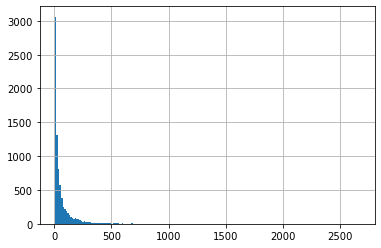

In [99]:
#forhist=edgeListAfter.groupby(level=0).size().hist(bins=200)
#edgeListAfterT=edgeListAfter.groupby(level=0).filter(lambda x: 500 >x.size)
#edgeListAfterT.groupby(level=0).size().min()

In [121]:
edgesBefore = edgeListBefore.reset_index()
edgesAfter = edgeListAfter.reset_index()

In [122]:
edgesAfter

,source,target,votes_neg_count,votes_pos_count,weight
0,77,13770,0,1,1
1,77,23862,0,1,1
2,77,178608,0,1,1
3,77,179687,0,1,1
4,77,606522,0,1,1
...,...,...,...,...,...
516934,694352,556329,1,0,-1
516935,694352,574246,0,1,1
516936,694352,601789,0,1,1
516937,694352,603620,0,1,1


In [123]:
edgesBefore.to_csv("../data/votes_to_comments_before.csv", index=False)
edgesAfter.to_csv("../data/votes_to_comments_after.csv", index=False)

### Graph

We use the *networkx* library.
Since we build a *votes-to-network* we have *source* nodes and *target* nodes. 
Thus, the network is directed.
Therefore, we use *nx.Digraph()*

In [124]:
edgesBefore = pd.read_csv("../data/votes_to_comments_before.csv")
edgesAfter = pd.read_csv("../data/votes_to_comments_after.csv")

In [125]:
G = nx.from_pandas_edgelist(edgesAfter, 
                            source='source', 
                            target='target', 
                            edge_attr = 'weight',
                            create_using=nx.DiGraph())

In [126]:
UG = G.to_undirected()

In [127]:
for node in G:
    for ngbr in nx.neighbors(G, node):
        if node in nx.neighbors(G, ngbr):
            UG.edges[node, ngbr]['weight'] = (np.where( 
                G.edges[node, ngbr]['weight'] + G.edges[ngbr, node]['weight'] >=0,1,-1)
            )

In [ ]:
# ## or CUDA (CuGraph variant)
# edgesBefore = cudf.read_csv("../data/votes_to_comments_before.csv")
# edgesAfter = cudf.read_csv("../data/votes_to_comments_after.csv")

# G = cnx.DiGraph()
# G = cnx.from_cudf_edgelist(edgesAfter, 
#                             source ='source', 
#                             destination ='target',
#                             edge_attr = 'weight')

In [128]:
## does not compute 
fig = plt.figure(figsize=(50,50))
nx.draw_spring(G)
plt.show()

KeyboardInterrupt: 

<Figure size 3600x3600 with 0 Axes>

### Basic Stats

In [137]:
print(nx.info(G),nx.info(UG))

Name: 
Type: DiGraph
Number of nodes: 19311
Number of edges: 516939
Average in degree:  26.7691
Average out degree:  26.7691 Name: 
Type: Graph
Number of nodes: 19311
Number of edges: 509224
Average degree:  52.7393


In [134]:
edges = UG.edges()
edges
# number of edges with weight 1
len(edgesBefore[edgesBefore.weight == -1])

49698

In [135]:
len(edges)

509224

In [ ]:
# max weight of edges
edges.weight.max()

In [ ]:
# average weight 
edges.weight.mean()

### Network density and path lengths

In [ ]:
# network density
nx.density(G)

In [ ]:
# Average distance (i.e. average shortest path length)
nx.average_shortest_path_length(G)

The method average_shortest_path_length throws an exception if the underlying Graph is disconnected. Thus, one can calculate the average of all finite distances (i.e., existing shortest pathes) nx.single_source_shortest_path_length(G, N) delivers the length of all shortest pathes beginning from node N. Furthermore, the first shortest path is always the distance to itself (i.e., zero), which as to be filtered later on.

In [ ]:
# compute all distances
distances = [list(nx.single_source_shortest_path_length(G,N).values()) for N in G.nodes]
# Flatten the distances list! Currently list of lists of single node distances
# and filter out the unnecessary zeroes
distances = [distance for single_distances in distances for distance in single_distances if distance > 0]

In [ ]:
# average
np.mean(distances)

To consider the weight one can use e.g. nx.single_source_dijkstra_path_length() But watch out, what does weight in our case mean?

In [ ]:
# Diameter (i.e, longest shortest path)
np.max(distances)

### Connected components

G.subgraph(c) for c in nx.weakly_connected_components(G) delivers a Generator,which can be used to iterate over all weakly connected compontents (deliverd as a subgraph for further analysis)

In [ ]:
wccs = [c for c in (G.subgraph(c) for c in nx.weakly_connected_components(G))]

In [ ]:
# number of wccs
len(wccs)

In [ ]:
# number of wccs
nx.number_weakly_connected_components(G)

Sizes of the wccs:

nx.number_of_nodes() delivers the number of nodes of a graph. This can be done for all weakly connected components wcc in the weakly connected component list. Furthermore, with set() one can get the uniqe values.

In [ ]:
set([nx.number_of_nodes(wcc) for wcc in wccs])

If not the uniqe values are in focus, but the for example how often a wcc with n Nodes appear, one can use Counter().most_common() as follwing

In [ ]:
from collections import Counter
Counter([nx.number_of_nodes(wcc) for wcc in wccs]).most_common()

Strongly connected components:

In [ ]:
sccs = [c for c in (G.subgraph(c) for c in nx.strongly_connected_components(G))]
Counter([nx.number_of_nodes(scc) for scc in sccs]).most_common()

### Clustering Coefficients

**Local**

nx.clustering(G) returns back a dictionary with clustering coefficients of each node.
with the combination of sorted() and itemgetter() one can get a sorted list of (ID,clustering coeff.) tuples.

In [ ]:
from operator import itemgetter
sorted(nx.clustering(G).items(), key=itemgetter(1), reverse=True)[:5]

"*the clustering coefficient quantifies how close the neighbours of i are to being a clique.*" (lecture slides) i.e., how concentrated the neighbours of a nodes is.

**Global**

The global clustering coefficient can have alternative definitions:

1) as the average of the local clustering coefficients

In [ ]:
nx.average_clustering(G)

Note, that there might be differences if you use other tools (e.g., Gephi, Igraph, etc.).
So, why does networkx delivers a different average clustering coefficiet?
In order to find an answer, take a look at the nx.clustering() documentation (since nx.average_clustering is just averaging over the individual values). https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html
It says, that clustering coefficients for nodes with degrees lower than 2 is set to ZERO.

Thus, there is no right or wrong way of implementation, but you have to be aware what you are using.

2) as the ratio of triangles and connected triples

In [ ]:
nx.transitivity(G)

### Centrality Indices

**In-Degree**

[nx.in_degree_centrality(G)](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html#networkx.algorithms.centrality.in_degree_centrality) delivers in-degree-centrality of each node in a graph G.
Note, that the centralities are normalized.


With a combination of sorted() and itemgetter() one can again get a sorted list of (Node, centrality) tuples.
Where one can just take the first 5 for reporting.
Note, reverse=True means in decreasing order



In [ ]:
sorted(nx.in_degree_centrality(G).items(), key=itemgetter(1), reverse=True)[:5]

User *588542* is replied the most.

**Out-Degree**

In [ ]:
sorted(nx.out_degree_centrality(G).items(), key=itemgetter(1), reverse=True)[:5]

User *588542* also replies the most

**Eigenvector-Centrality**

Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. The eigenvector centrality for node i is the i-th element of the vector 𝑥 defined by the equation

𝐴𝑥=𝜆𝑥

where 𝐴 is the adjacency matrix of the graph G with eigenvalue 𝜆. By virtue of the Perron–Frobenius theorem, there is a unique solution 𝑥, all of whose entries are positive, if 𝜆 is the largest eigenvalue of the adjacency matrix 𝐴
A.

In [ ]:
sorted(nx.eigenvector_centrality(G).items(), key=itemgetter(1), reverse=True)[:5]

**In-closeness centrality**

Closeness centrality of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.

𝐶(𝑢)= (𝑛−1)/∑𝑑(𝑣,𝑢)

where d(v, u) is the shortest-path distance between v and u, and n is the number of nodes that can reach u. Notice that the closeness distance function computes the incoming distance to u for directed graphs. To use outward distance, act on G.reverse().

In [ ]:
sorted(nx.closeness_centrality(G).items(), key=itemgetter(1), reverse=True)[:5]

**Out-closeness centrality**

In [ ]:
sorted(nx.closeness_centrality(G.reverse()).items(), key=itemgetter(1), reverse=True)[:5]

**Betweeness centrality**

Betweenness centrality of a node 𝑣 is the sum of the fraction of all-pairs shortest paths that pass through 𝑣

𝑐𝐵(𝑣)=∑𝜎(𝑠,𝑡|𝑣)/𝜎(𝑠,𝑡)

where, 𝜎(𝑠,𝑡) is the number of shortest (𝑠,𝑡)-paths, and 𝜎(𝑠,𝑡|𝑣) is the number of those paths passing through some node 𝑣 other than 𝑠,𝑡 .


Using k=100 nodes to estimate the betweeness centrality.

In [ ]:
sorted(nx.betweenness_centrality(G, k=100).items(), key=itemgetter(1), reverse=True)[:5]

### Link Analysis

**Hubs and Authorities**

In [ ]:
hubs_auth = nx.hits(G)

In [ ]:
# hub scores
sorted(hubs_auth[0].items(), key=itemgetter(1), reverse=True)[:5]

In [ ]:
# authority scores
sorted(hubs_auth[1].items(), key=itemgetter(1), reverse=True)[:5]

**Page Rank**

In [ ]:
sorted(nx.pagerank(G).items(), key=itemgetter(1), reverse=True)[:5]

# Triadic Census

In [ ]:
nx.algorithms.triads.triadic_census(G)

In [2]:
from nxtriads import triads_by_type
### Copied source code instead of updating to NetworkX == 2.5
### see file nxtriads.py
## __all__ = ["triadic_census", "is_triad", "all_triplets", "all_triads",
## "triads_by_type", "triad_type", "random_triad", ]

# convenience
from networkx import nx
import pandas as pd

In [5]:
edges5d = pd.read_csv("../data/votes_to_comments_5days.csv")
G5 = nx.from_pandas_edgelist(edges5d, 
                            source='source', 
                            target='target', 
                            edge_attr = 'weight',
                            create_using=nx.DiGraph())
print(nx.info(G5))

Name: 
Type: DiGraph
Number of nodes: 7378
Number of edges: 85359
Average in degree:  11.5694
Average out degree:  11.5694


In [ ]:
## kills kernel every time (pushes RAM >>10gb even on tiny graph)
triads_5 = triads_by_type(G5)

In [ ]:

#triads_5.keys()